In [1]:
import numpy as np
import requests
from io import StringIO
from pandas import read_csv
from astropy.io import ascii
from astropy.stats import LombScargle as ls
import astropy.coordinates as coord
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

### Generate URL Request with Cone Search and Load Decoded Response into a Pandas DataFrame

In [2]:
# Search Coordinates
ra = 295.3541416 # Search RA
dec = 15.3818178 # Search Dec
rad = 0.001      # Search Radius in Degrees

# Generate URL to query the ZTF Light Curve Database
base_url = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?"
pos_string = "POS=CIRCLE {:.5f} {:.5f} {:.5f}&FORMAT=csv".format(ra,dec,rad)
search_url = base_url + pos_string

# Perform request and decode response into a Pandas DataFrame
response = requests.get(search_url)
data = read_csv(StringIO(response.content.decode('utf-8')))


### Separate into g & r Light Curves and Filter out Bad Data Points with *catflags* Keyword

In [3]:
gdata = data[(data.filtercode == 'zg') & (data.catflags == 0)].sort_values(by='mjd').reset_index(drop=True)
rdata = data[(data.filtercode == 'zr') & (data.catflags == 0)].sort_values(by='mjd').reset_index(drop=True)

# Get Coordinates from one of the light curve entries
c = coord.SkyCoord(gdata.ra.iloc[0],gdata.dec.iloc[0],unit='deg',frame='icrs')
cstring = c.to_string('hmsdms',sep=':',precision=2)

### Plot the ZTF Light Curves

Text(0.5, 1.0, 'RA = 19:41:24.99  Dec = +15:22:54.54,  Ng = 276,  Nr = 258')

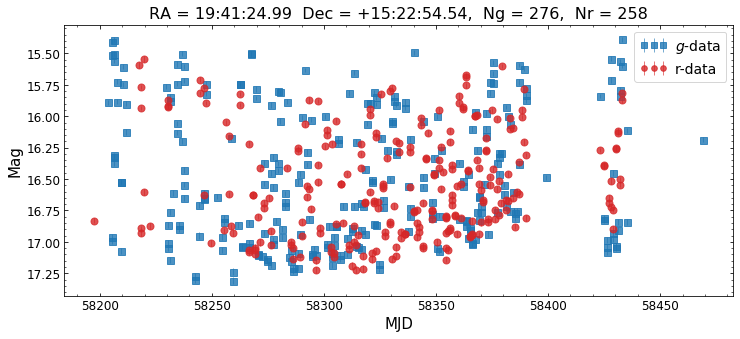

In [4]:
figa = plt.figure('a',figsize=(12,5))
ax = figa.add_subplot(111)

# Plot g & r data
ax.errorbar(gdata.mjd,gdata.mag,yerr=gdata.magerr,
            ls='None',marker='s',ms=7,mfc='C0',mec='C0',
            ecolor='C0',elinewidth=0.75,alpha=0.8)
ax.errorbar(rdata.mjd,rdata.mag,yerr=rdata.magerr,
            ls='None',marker='o',ms=7,mfc='C3',mec='C3',
            ecolor='C3',elinewidth=0.75,alpha=0.8)

# Set Plot Appearances
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('MJD',fontsize=15)
ax.set_ylabel('Mag',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='both',axis='both',direction='in',
               right=True,top=True,labelsize=12)
ax.legend(('$\it{g}$-data','r-data'),fontsize=14,
           handletextpad=0.5,numpoints=3,markerscale=0.8)

# Create Plot Title With Coordinates and Data Counts
title_a = 'RA = {}  Dec = {},  Ng = {},  Nr = {}'.format(cstring.split(" ")[0],cstring.split(" ")[1],
                                                        len(gdata),len(rdata))
ax.set_title(title_a,fontsize=16)

### Convert Light Curves into Percent Flux Change Relative to Median Magnitudes

In [5]:
# Convert times to seconds relative to earliest data point
tref = min(min(gdata.mjd),min(rdata.mjd))
tsg = (gdata.mjd.values - tref) * 86400.0
tsr = (rdata.mjd.values - tref) * 86400.0
sort_ind = np.argsort(np.concatenate((tsg,tsr)))
tsa = np.concatenate((tsg,tsr))[sort_ind]

# Normalize the magnitudes
gmag_norm = 10.0**(0.4*(gdata.mag.median()-gdata.mag.values)) - 1.0
rmag_norm = 10.0**(0.4*(rdata.mag.median()-rdata.mag.values)) - 1.0
amag_norm = np.concatenate((gmag_norm,rmag_norm))[sort_ind]

# Calculate errors on normalized magnitudes
gmag_norm_err = gdata.magerr.values / 1.086
rmag_norm_err = rdata.magerr.values / 1.086
amag_norm_err = np.concatenate((gmag_norm_err,rmag_norm_err))[sort_ind]


### Calculate Lomb Scargle Periodgrams for the *g, r*, and combined ZTF Light Curves

In [6]:
# Function to Calculate Lomb-Scargle Periodogram (LSP) with Amplitude Units
def calc_lsp(t,a,f):
    lsp = ls(t,a).power(f,normalization='psd')
    norm_lsp = np.sqrt(abs(4.0*(lsp/len(t))))
    return norm_lsp

# Calculate LSP for g, r, & combined light curves
fnyq = 0.005
fres = 1.0e-8
farr = np.linspace(1e-6,fnyq,int(fnyq/fres))
glsp = calc_lsp(tsg,gmag_norm,farr)
rlsp = calc_lsp(tsr,rmag_norm,farr)
alsp = calc_lsp(tsa,amag_norm,farr)

### Plot the Normalized ZTF Light Curves and Lomb-Scargle Periodograms

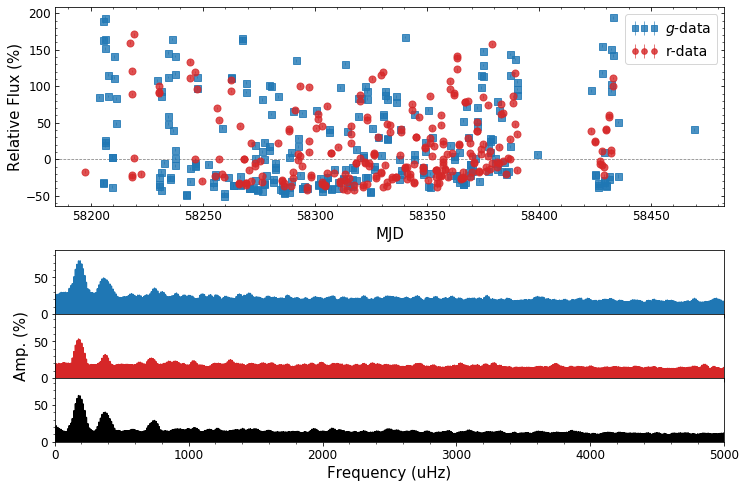

In [7]:
figb = plt.figure('b',figsize=(12,8))
gsb = GridSpec(5,1,height_ratios=[2.5,0.55,0.8,0.8,0.8],hspace=0)
bx0 = figb.add_subplot(gsb[0])
bx1 = figb.add_subplot(gsb[2])
bx2 = figb.add_subplot(gsb[3])
bx3 = figb.add_subplot(gsb[4])

# Plot Normalized g & r Flux 
bx0.errorbar(gdata.mjd,gmag_norm*1e2,yerr=gmag_norm_err*1e2,
             ls='None',marker='s',ms=7,mfc='C0',mec='C0',
             ecolor='C0',elinewidth=0.75,alpha=0.8)
bx0.errorbar(rdata.mjd,rmag_norm*1e2,yerr=rmag_norm_err*1e2,
             ls='None',marker='o',ms=7,mfc='C3',mec='C3',
             ecolor='C3',elinewidth=0.75,alpha=0.8)
bx0.axhline(0,ls='--',c='k',lw=0.75,alpha=0.5,label='_nolegend_')

# Plot the Lomb-Scargle Periodograms
bx1.plot(farr*1e6,glsp*1e2,ls='-',c='C0')
bx2.plot(farr*1e6,rlsp*1e2,ls='-',c='C3')
bx3.plot(farr*1e6,alsp*1e2,ls='-',c='k')

# Set Plot Appearances
bx0.set_xlabel('MJD',fontsize=15)
bx0.set_ylabel('Relative Flux (%)',fontsize=15)
bx3.set_xlabel('Frequency (uHz)',fontsize=15)
bx2.set_ylabel('Amp. (%)',fontsize=15)
bx1.set_xlim(0,5000)
bx2.set_xlim(bx1.get_xlim())
bx3.set_xlim(bx1.get_xlim())
bx1.set_ylim(0,1.2*max([max(glsp),max(rlsp),max(alsp)])*1e2)
bx2.set_ylim(bx1.get_ylim())
bx3.set_ylim(bx1.get_ylim())
bx0.minorticks_on()
bx1.minorticks_on()
bx2.minorticks_on()
bx3.minorticks_on()
bx0.tick_params(which='both',axis='both',direction='in',
                right=True,top=True,labelbottom=True ,labelsize=12)
bx1.tick_params(which='both',axis='both',labelbottom=False,labelsize=12)
bx2.tick_params(which='both',axis='both',labelbottom=False,labelsize=12)
bx3.tick_params(which='both',axis='both',labelbottom=True ,labelsize=12)
bx0.legend(('$\it{g}$-data','r-data'),fontsize=14,
           handletextpad=0.5,numpoints=3,markerscale=0.8)

### Pick out the Maximum Peak in the Combined Lomb-Scargle Periodogram as a Folding Period

In [8]:
# Designate a folding period as max peak in the combined Lomb-Scargle Periodogram
max_freq = farr[alsp == max(alsp)][0]
pfold = 1./max_freq

# Calculate the phases
phases_g = (tsg / pfold) % 1.0
phases_r = (tsr / pfold) % 1.0

print('Folding Freq.  = {:.3f} uHz'.format(max_freq*1e6))
print('Folding Period = {:.3f} sec'.format(pfold))

Folding Freq.  = 178.465 uHz
Folding Period = 5603.344 sec


### Plot Four Cycles of the Phase Folded ZTF Light Curve

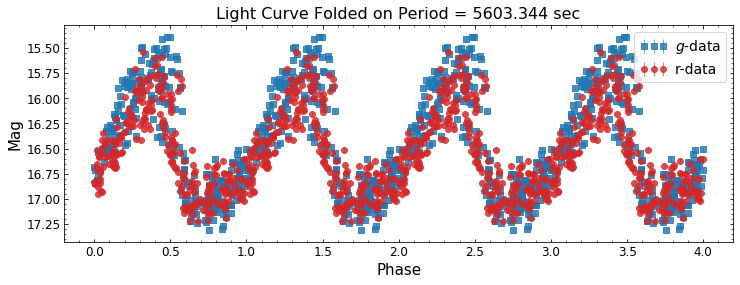

In [9]:
figc = plt.figure('c',figsize=(12,4))
cx = figc.add_subplot(111)

# Plot the Phase Folded ZTF Light Curves
for i in range(4):
    cx.errorbar(phases_g+float(i),gdata.mag,yerr=gdata.magerr,
                ls='None',marker='s',ms=6,mfc='C0',mec='C0',
                ecolor='C0',elinewidth=0.75,alpha=0.8)
    cx.errorbar(phases_r+float(i),rdata.mag,yerr=rdata.magerr,
                ls='None',marker='o',ms=6,mfc='C3',mec='C3',
                ecolor='C3',elinewidth=0.75,alpha=0.8)

# Flip y-axis
cx.set_ylim(cx.get_ylim()[::-1])

# Add Title Showing Folding Period
title = 'Light Curve Folded on Period = {:.3f} sec'.format(pfold)
cx.set_title(title,fontsize=16)

# Add a legend
cx.legend(('$\it{g}$-data','r-data'),fontsize=14,
           handletextpad=0.5,numpoints=3)

# Add xy-labels
cx.set_xlabel('Phase',fontsize=15)
cx.set_ylabel('Mag',fontsize=15)
cx.minorticks_on()
cx.tick_params(which='both',axis='both',direction='in',
               right=True,top=True,labelsize=12)